In [ ]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation
import jax
import jax.numpy as jnp

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from HOSim import solver
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

for file_index in range(3):
    y, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None

    with h5py.File(h5_files[1+file_index], "r") as data:
        y = data["y"][100:]
        Hs = data.attrs["Hs"]
        Tp = data.attrs["Tp"]

        modes = data.attrs["modes"]
        length = data.attrs["length"]
        Ta = data.attrs["Ta"]
        x = np.linspace(0, length, 2*modes)

    index = 0

    eta_hat = y[index:index+121, 0]
    phi_hat = y[index:index+121, 1]

    mes_index_1 = np.argmin(np.abs(x - 1300))
    mes_index_2 = np.argmin(np.abs(x - 1700))

    eta = irfft2(eta_hat).astype(np.float32)
    phi = irfft2(phi_hat).astype(np.float32)

    eta[:, mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 0
    phi[:, mes_index_1:mes_index_2, mes_index_1:mes_index_2] = 0

    ##
    for i in range(mes_index_1, mes_index_2):
        eta[0, mes_index_1:mes_index_2, i] = (eta[0, mes_index_1-1, i] + eta[0, mes_index_2+1, i]) * 0.5 # juks?
    ##

    eta_hat = rfft2(eta).astype(np.complex64)
    phi_hat = rfft2(phi).astype(np.complex64)

    modes = eta_hat.shape[-1]-1
    mHOS = 4
    index = modes * 2 // (mHOS + 1)
    alias_mask = np.ones((2*modes, modes+1))
    alias_mask[index+1:-index, :] = 0
    alias_mask[:, index+1:] = 0

    eta_hat = eta_hat * alias_mask
    phi_hat = phi_hat * alias_mask

    eta = irfft2(eta_hat).astype(np.float32)
    phi = irfft2(phi_hat).astype(np.float32)

    f_jit = jax.jit(solver.f2d, static_argnums=(2, 3, 4, 5, 6))
    rk4_step_jit = solver.rk4_step

    eta_hat_0 = jnp.asarray(eta_hat[0])
    phi_hat_0 = jnp.asarray(phi_hat[0])

    y_hat = jnp.stack([eta_hat_0, phi_hat_0])
    modes = y_hat.shape[-1]-1
    k0 = 2 * np.pi / length

    L1 = np.ones(eta_hat_0.shape[-2:])*2
    L1[0, 0] = 0
    ky = np.arange(0, modes+1)*k0
    kx = np.concatenate((ky, -ky[1:-1][::-1]))
    KX, KY = jnp.meshgrid(kx, ky, indexing="ij")
    K = np.sqrt(KX**2 + KY**2)
    L2 = 1.0 / K - 9.81
    L2[0, 0] = 0

    y_hat = y_hat.at[0, 31:-31, :].set(0)
    y_hat = y_hat.at[1, 31:-31, :].set(0)

    plt.plot(irfft2(y_hat[0])[modes, :])
    plt.plot(irfft2(y[0, 0])[modes, :])
    plt.show()

    plt.plot(irfft2(y_hat[1])[modes, :])
    plt.plot(irfft2(y[0, 1])[modes, :])
    plt.show()

    sim_mins = 6+6
    y_saved = np.zeros((sim_mins*10+1, *y_hat.shape), dtype=np.complex64)
    y_saved[0] = y_hat

    for i in range(sim_mins):
        for j in range(1, 401):
            y_hat = rk4_step_jit(200, y_hat, 0.025, modes, 9.81, k0, 4, 0.001, f_jit)
            y_hat = y_hat.at[0, 31:-31, :].set(0)
            y_hat = y_hat.at[1, 31:-31, :].set(0)

            if j % 40 == 0:
                y_saved[i*10+j//40] = y_hat
                plt.plot(irfft2(y_hat[0])[modes, :])
                plt.plot(irfft2(y[j//40, 0])[modes, :])
                plt.show()

        if i < 6:
            print("old")
            y_old = irfft2(y_hat)
            plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
            plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
            plt.legend()
            plt.show()

            y_obs = irfft2(y[(i+1)*10, 0])
            y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
            y_obs_hat = rfft2(y_obs)
            y_hat = y_hat.at[0].add(0.5 * L1 * (y_obs_hat - y_hat[0]))
            y_hat = y_hat.at[1].add(0.5 * L2 * (y_obs_hat - y_hat[0]))

            print("corrected")
            plt.plot(irfft2(y_hat[0])[modes, :], label="sim")
            plt.plot(irfft2(y[(i+1)*10, 0])[modes, :], label="Actual")
            plt.legend()
            plt.show()

        print(f"{i}-done")

    np.savez_compressed(f'physical_2d_full_{file_index}.npz', y_saved=y_saved)

# Results

The Fourier Neural Operator (FNO) significantly outperforms the Artificial Neural Network (ANN) in terms of prediction accuracy. This is largely due to the FNO's ability to capture patterns in the Fourier domain, making it particularly effective for modeling wave dynamics governed by partial differential equations (PDEs).

# Physical Approach

The physical approach is based on the Higher-Order Spectral (HOS) method with order 8, combined with a Luenberger observer. Wave fields are time-integrated both forward and backward over the measurement window before being propagated to the target location in time.

The resulting predictions are shown below. You can view an animation of how the physical approach works here: [Physical Wave Prediction](https://vegabaar.folk.ntnu.no/wave_prediction_HOSM.html)


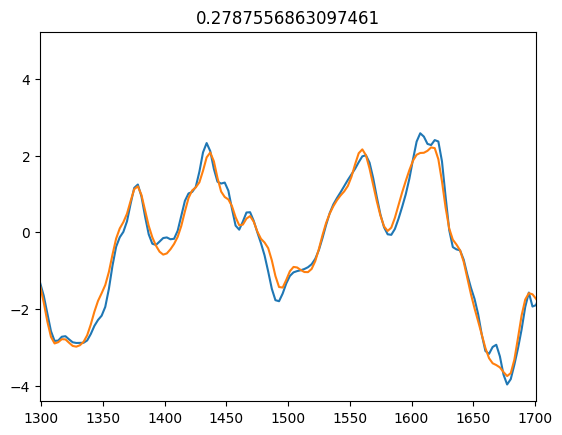

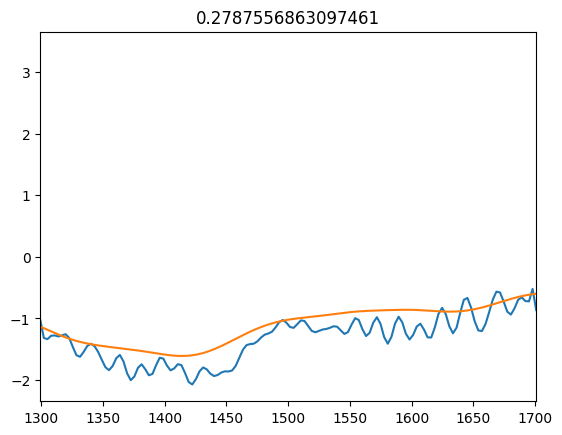

In [12]:
plt.plot(x, irfft2(y_hat[0])[modes, :])
plt.plot(x, irfft2(y[120, 0])[modes, :])
plt.xlim(x[mes_index_1], x[mes_index_2])
error = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2] - irfft2(y[120, 0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
RMSE = np.sqrt(np.mean(error**2))
plt.title(RMSE)
plt.show()

plt.plot(x, irfft2(y_hat[0])[:, modes])
plt.plot(x, irfft2(y[120, 0])[:, modes])
plt.xlim(x[mes_index_1], x[mes_index_2])
error = irfft2(y_hat[0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2] - irfft2(y[120, 0])[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
RMSE = np.sqrt(np.mean(error**2))
plt.title(RMSE)
plt.show()

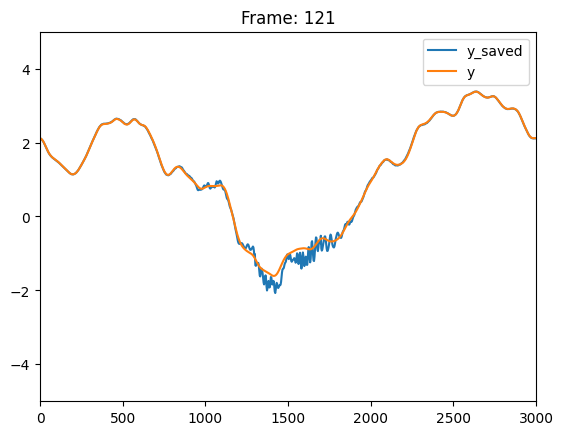

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numpy.fft import irfft2

fig, ax = plt.subplots()

line1, = ax.plot([], [], label='y_saved')
line2, = ax.plot([], [], label='y')
ax.legend()

ax.set_xlim(0, x[-1])
ax.set_ylim(-5, 5)

def update(frame):
    ys = irfft2(y_saved[frame, 0])[:, modes]
    y_orig = irfft2(y[frame, 0])[:, modes]
    line1.set_data(x, ys)
    line2.set_data(x, y_orig)
    ax.set_title(f"Frame: {frame+1}")
    return line1, line2

# Keep a strong reference to the animation object
ani = FuncAnimation(fig, update, frames=121, blit=True)
ani.save('short_animation.gif', writer=PillowWriter(fps=10))
plt.show()


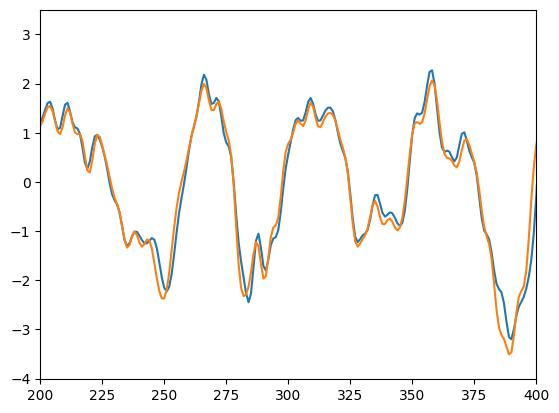

In [ ]:
i = 0
y_sim = irfft2(y_hat[0])
y_obs = irfft2(eta_hat[(i+1)*10])
y_obs[mes_index_1:mes_index_2, mes_index_1:mes_index_2] = y_sim[mes_index_1:mes_index_2, mes_index_1:mes_index_2]
plt.plot(y_sim[modes, :])
plt.plot(y_obs[modes, :])
plt.show()

In [3]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft2, irfft2
from matplotlib.animation import FuncAnimation
import jax
import jax.numpy as jnp

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

data = np.load("physical_2d_1.npz")
eta = irfft2(data["y_saved"][:, 0, :, :])

(721, 2, 1024, 513)
